#   Módulo 11 Customer Analytics - Sprint 3
#   David José Talavera Hierro
#   IEBS

In [19]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

df = pd.read_csv('C:\\Users\David\Code projects\IEBS\EDA\Transactions.csv', delimiter = ';')

In [20]:
df.head()

,orderId,clientId,product,gender,orderdate,Quantity,Price
0,1,255,g,female,03/01/2017,3,5
1,1,255,a,female,03/01/2017,3,14
2,1,255,b,female,03/01/2017,3,22
3,1,255,a,female,03/01/2017,1,14
4,2,145,h,male,05/01/2017,1,26


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4805 entries, 0 to 4804
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   orderId    4805 non-null   int64 
 1   clientId   4805 non-null   int64 
 2   product    4805 non-null   object
 3   gender     4805 non-null   object
 4   orderdate  4805 non-null   object
 5   Quantity   4805 non-null   int64 
 6   Price      4805 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 262.9+ KB


In [22]:
df['orderdate'] = pd.to_datetime(df['orderdate'], format='%d/%m/%Y')

### Agrupación de datos por clientes y obtención de columnas relevantes para la clusterización.

In [23]:
df['Total'] = df['Quantity'] * df['Price']
df_totalclient = df.groupby('orderId').agg({'clientId': "max", 'product': "count", 'gender': "first", 'orderdate': "max", 'Quantity': "sum", 'Total': "sum"})
df_totalclient = df_totalclient.sort_values(['clientId', 'orderdate'])
df_totalclient['frequency'] = 0
df_totalclient.head(10)

,clientId,product,gender,orderdate,Quantity,Total,frequency
orderId,,,,,,,
518,1,5,female,2017-02-11,14,322,0
131,1,2,female,2017-02-18,2,37,0
673,1,4,female,2017-02-24,9,152,0
548,2,6,male,2017-01-16,13,214,0
716,2,7,male,2017-01-24,16,307,0
588,2,9,male,2017-02-02,14,302,0
545,2,8,male,2017-02-05,16,231,0
122,2,5,male,2017-03-30,11,175,0
952,3,4,female,2017-02-26,9,137,0


In [24]:
df_totalclient['frequency'] = df_totalclient.groupby('clientId')['orderdate'].diff().dt.days
df_totalclient = df_totalclient.reset_index()
df_totalclient.head(10)

,orderId,clientId,product,gender,orderdate,Quantity,Total,frequency
0,518,1,5,female,2017-02-11,14,322,NaN
1,131,1,2,female,2017-02-18,2,37,7.0
2,673,1,4,female,2017-02-24,9,152,6.0
3,548,2,6,male,2017-01-16,13,214,NaN
4,716,2,7,male,2017-01-24,16,307,8.0
5,588,2,9,male,2017-02-02,14,302,9.0
6,545,2,8,male,2017-02-05,16,231,3.0
7,122,2,5,male,2017-03-30,11,175,53.0
8,952,3,4,female,2017-02-26,9,137,NaN
9,708,4,2,male,2017-01-05,5,96,NaN


In [25]:
df_summary = df_totalclient.groupby('clientId').agg(total_orders=('orderId', 'count'),
                                                    product=('product', 'sum'),      
                                                    gender=('gender', 'first'),     
                                                    sum_quantity=('Quantity', 'sum'),
                                                    mean_quantity=('Quantity', 'mean'),    
                                                    sum_total=('Total', 'sum'),
                                                    mean_total=('Total', 'mean'),          
                                                    frequency=('frequency', 'mean')
                                                    )
df_summary['gender_binary'] = df_summary['gender'].map({'male': 0, 'female': 1})
df_summary['Priceperproduct']=df_summary['sum_total']/df_summary['sum_quantity']
df_summary.head()

,total_orders,product,gender,sum_quantity,mean_quantity,sum_total,mean_total,frequency,gender_binary,Priceperproduct
clientId,,,,,,,,,,
1,3,11,female,25,8.333333,511,170.333333,6.50,1,20.440000
2,5,35,male,70,14.000000,1229,245.800000,18.25,0,17.557143
3,1,4,female,9,9.000000,137,137.000000,NaN,1,15.222222
4,5,24,male,50,10.000000,885,177.000000,14.00,0,17.700000
5,3,19,male,34,11.333333,609,203.000000,17.50,0,17.911765


In [26]:
scaler = MinMaxScaler(feature_range=(0, 100))
df_summary['total_orders_normalized'] = scaler.fit_transform(df_summary[['total_orders']])
df_summary['total_product_normalized'] = scaler.fit_transform(df_summary[['product']])
df_summary['sum_total_normalized'] = scaler.fit_transform(df_summary[['sum_total']])
df_summary['mean_total_normalized'] = scaler.fit_transform(df_summary[['mean_total']])
df_summary['sum_quantity_normalized'] = scaler.fit_transform(df_summary[['sum_quantity']])
df_summary['mean_quantity_normalized'] = scaler.fit_transform(df_summary[['mean_quantity']])
df_summary['gender_binary_normalized'] = scaler.fit_transform(df_summary[['gender_binary']])
df_summary['Priceperproduct_normalized'] = scaler.fit_transform(df_summary[['Priceperproduct']])
df_summary['frequency_normalized'] = scaler.fit_transform(df_summary[['frequency']])
df_summary['frequency_normalized'] = df_summary['frequency_normalized'].fillna(100)

columns_to_round = ['mean_quantity', 'sum_total', 'mean_total', 'frequency', 'sum_total_normalized', 'mean_total_normalized', 'frequency_normalized', 'mean_quantity_normalized', 'Priceperproduct_normalized']
df_summary[columns_to_round] = df_summary[columns_to_round].round(2)
df_summary.head(10)

,total_orders,product,gender,sum_quantity,mean_quantity,sum_total,mean_total,frequency,gender_binary,Priceperproduct,total_orders_normalized,total_product_normalized,sum_total_normalized,mean_total_normalized,sum_quantity_normalized,mean_quantity_normalized,gender_binary_normalized,Priceperproduct_normalized,frequency_normalized
clientId,,,,,,,,,,,,,,,,,,,
1,3,11,female,25,8.33,511,170.33,6.50,1,20.440000,28.571429,19.230769,25.88,45.42,23.300971,40.74,100.0,67.79,6.77
2,5,35,male,70,14.00,1229,245.80,18.25,0,17.557143,57.142857,65.384615,62.61,66.15,66.990291,72.22,0.0,55.13,19.01
3,1,4,female,9,9.00,137,137.00,NaN,1,15.222222,0.000000,5.769231,6.75,36.26,7.766990,44.44,100.0,44.88,100.00
4,5,24,male,50,10.00,885,177.00,14.00,0,17.700000,57.142857,44.230769,45.01,47.25,47.572816,50.00,0.0,55.76,14.58
5,3,19,male,34,11.33,609,203.00,17.50,0,17.911765,28.571429,34.615385,30.90,54.40,32.038835,57.41,0.0,56.69,18.23
6,5,32,male,63,12.60,1116,223.20,20.75,0,17.714286,57.142857,59.615385,56.83,59.95,60.194175,64.44,0.0,55.82,21.61
7,1,3,female,8,8.00,160,160.00,NaN,1,20.000000,0.000000,3.846154,7.93,42.58,6.796117,38.89,100.0,65.85,100.00
8,2,13,male,29,14.50,497,248.50,3.00,0,17.137931,14.285714,23.076923,25.17,66.90,27.184466,75.00,0.0,53.29,3.12
9,2,11,female,25,12.50,320,160.00,66.00,1,12.800000,14.285714,19.230769,16.11,42.58,23.300971,63.89,100.0,34.24,68.75


### Se escogen las dimensiones más relevantes para analizar
*   Para ello se analiza con un mapa de calor las correlaciones entre variables

In [27]:
columns_to_clustering = []
for i in df_summary.columns:
    if 'normalized' in i:
        columns_to_clustering.append(i)
df_clustering = df_summary[columns_to_clustering]
df_clustering.head(10)

,total_orders_normalized,total_product_normalized,sum_total_normalized,mean_total_normalized,sum_quantity_normalized,mean_quantity_normalized,gender_binary_normalized,Priceperproduct_normalized,frequency_normalized
clientId,,,,,,,,,
1,28.571429,19.230769,25.88,45.42,23.300971,40.74,100.0,67.79,6.77
2,57.142857,65.384615,62.61,66.15,66.990291,72.22,0.0,55.13,19.01
3,0.000000,5.769231,6.75,36.26,7.766990,44.44,100.0,44.88,100.00
4,57.142857,44.230769,45.01,47.25,47.572816,50.00,0.0,55.76,14.58
5,28.571429,34.615385,30.90,54.40,32.038835,57.41,0.0,56.69,18.23
6,57.142857,59.615385,56.83,59.95,60.194175,64.44,0.0,55.82,21.61
7,0.000000,3.846154,7.93,42.58,6.796117,38.89,100.0,65.85,100.00
8,14.285714,23.076923,25.17,66.90,27.184466,75.00,0.0,53.29,3.12
9,14.285714,19.230769,16.11,42.58,23.300971,63.89,100.0,34.24,68.75


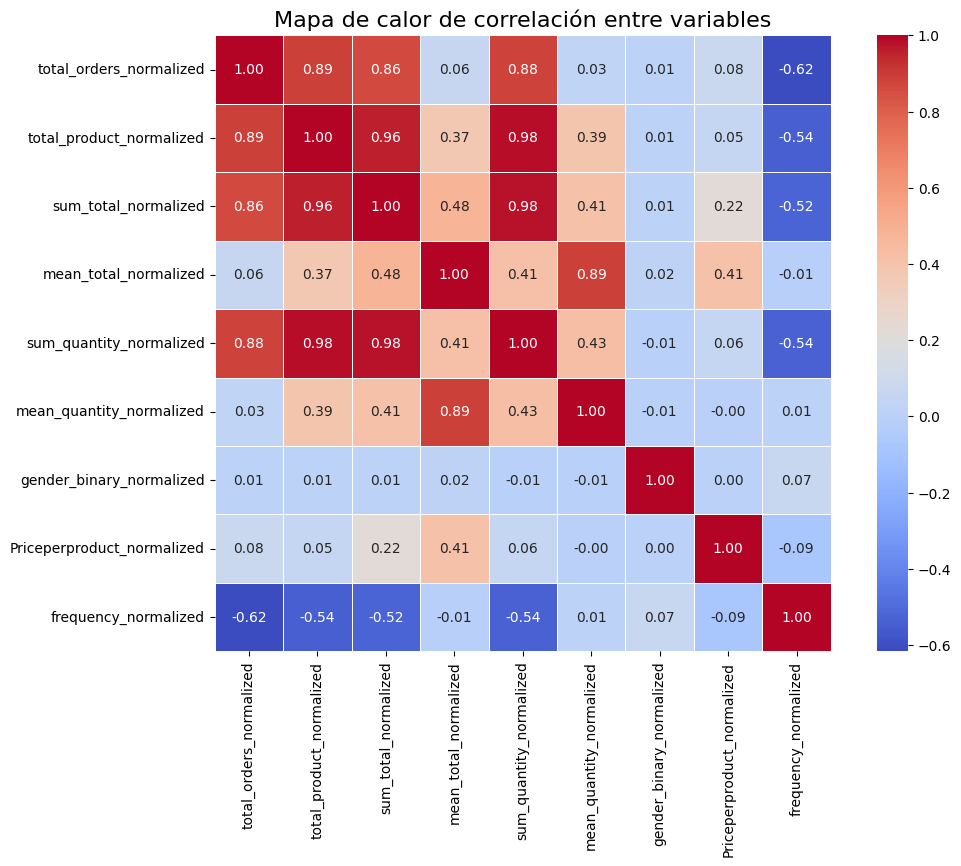

In [28]:
correlation_matrix = df_clustering.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, 
            square=True, linewidths=0.5, annot_kws={"size": 10})
plt.title('Mapa de calor de correlación entre variables', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

#   Selección final de variables para PCA:
*Incluidas:*

*   sum_total_normalized: Captura el importe total de ventas.
*   sum_quantity_normalized: Representa la cantidad total de artículos comprados.
*   mean_total_normalized: Refleja el gasto promedio por cliente.
*   Priceperproduct_normalized: Analiza el precio medio por producto.
*   frequency_normalized: Aporta información sobre el tiempo entre compras.

*Excluidas:*

*   total_orders_normalized y total_product_normalized (por redundancia con sum_total_normalized y sum_quantity_normalized).
*   mean_quantity_normalized (por correlación muy alta con otras variables).
*   gender_binary_normalized (por baja contribución a la segmentación).


#   Algoritmo PCA Reducción de la dimensionalidad

In [29]:
df_clustering=df_clustering.iloc[:,[2,3,4,7,8]]

In [30]:
df_clustering.columns

Index(['sum_total_normalized', 'mean_total_normalized',
       'sum_quantity_normalized', 'Priceperproduct_normalized',
       'frequency_normalized'],
      dtype='object')

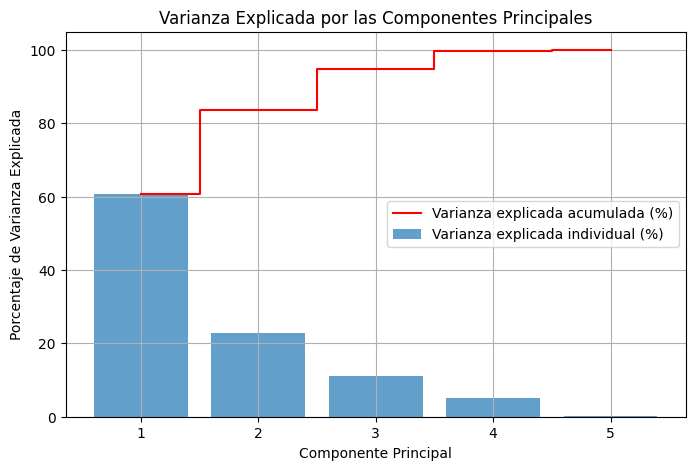

In [31]:
X = df_clustering.values
pca = PCA(n_components=5)
pca.fit(X)
X_pca = pca.transform(X)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum() 

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance * 100, alpha=0.7, align='center', 
        label='Varianza explicada individual (%)')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, where='mid', 
         label='Varianza explicada acumulada (%)', color='red')
plt.xlabel('Componente Principal')
plt.ylabel('Porcentaje de Varianza Explicada')
plt.title('Varianza Explicada por las Componentes Principales')
plt.legend(loc='best')
plt.grid()
plt.show()

     sum_total_normalized  mean_total_normalized  sum_quantity_normalized  \
PC1             -0.416155              -0.122816                -0.418165   
PC2              0.422393               0.591062                 0.366187   
PC3             -0.251648               0.326399                -0.420188   
PC4             -0.300159               0.727341                -0.180052   
PC5              0.703546              -0.000449                -0.694312   

     Priceperproduct_normalized  frequency_normalized  
PC1                   -0.068284              0.795114  
PC2                    0.247466              0.526211  
PC3                    0.773269             -0.235870  
PC4                   -0.559731             -0.187515  
PC5                   -0.151179             -0.009974  


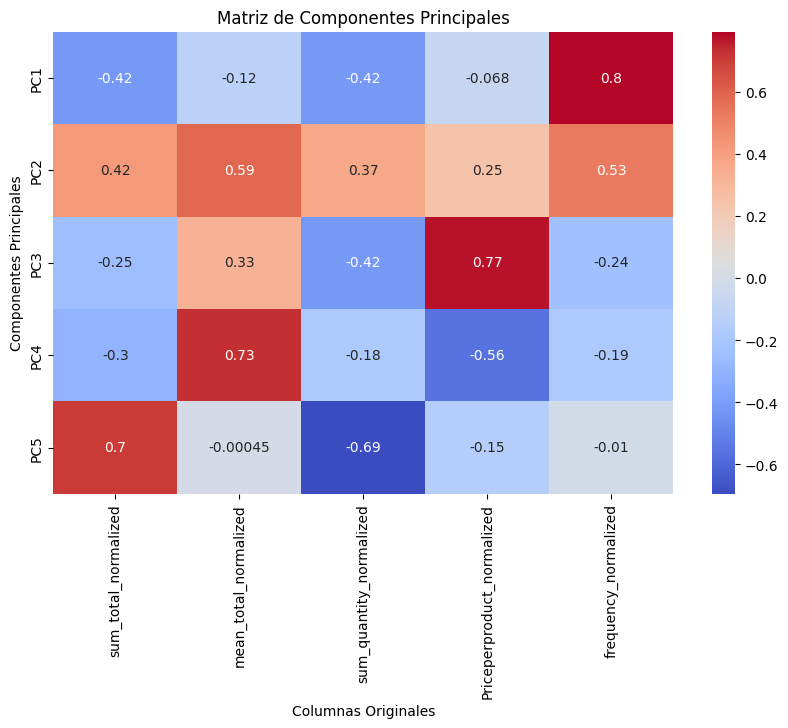

In [32]:
components = pca.components_   # Obtener la matriz de componentes principales
index = []

for i in range(components.shape[0]):
    index.append(f'PC{i+1}')

components_df = pd.DataFrame(components, columns=df_clustering.columns, index=index)
print(components_df)
# Se representa en un mapa de calor este DataFrame para mayor visibilidad
plt.figure(figsize=(10, 6))
sns.heatmap(components_df, annot=True, cmap='coolwarm', cbar=True)
plt.title('Matriz de Componentes Principales')
plt.xlabel('Columnas Originales')
plt.ylabel('Componentes Principales')
plt.show()

# Análisis de las componentes principales
*  PC1: un valor alto implica a clientes que compran con muy poca frecuencia, gastan poco y compran poca cantidad de producto. (Se buscará potenciar un valor de PC1 bajo)
*  PC2: clientes que aunque no compran con mucha frecuencia, sus compras tienen un importe medio elevado, con una cantidad e importe total moderado y un precio medio por producto relativamente alto. (Se buscará potenciar un valor de PC2 alto)
*  PC3: diferencia clientes que gastan más por producto frente a los que compran más cantidad. (Potenciar un valor alto o bajo dependerá del modelo de negocio)
*  PC4: gasto medio elevado y con mayor probabilidad de comprar productos baratos. 
*  PC5: distingue clientes con mayor importe total frente a mayor cantidad comprada.

###  Se mantienen 3 componentes principales pues explican más del 92% de la varianza acumulada, lo cual es más que suficiente. Estas 3 componentes (PC1, PC2 y PC3) reflejan diferencias en frecuencia, gasto promedio y relación entre el precio medio de los productos comprados y la cantidad comprada, que considero que son clave para segmentar clientes.

#   Cálculo del número de clusters óptimo

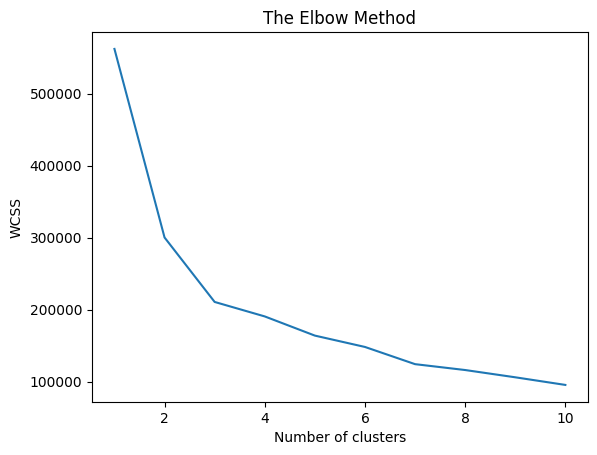

In [33]:
X = df_clustering.values
seed1 = 42  # Se establece el valor de la semilla

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = seed1)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

1.  El número óptimo de clusters es aquel que minimiza el valor de WCSS: "Within Cluster Sum of Squares", que es una métrica que nos ayuda a entender cuán similares son los datos dentro de un mismo cluster.
2.  Esto no quiere decir que un valor de 0 es lo más óptimo.
3.  Se busca aquel número de clusters que hace que añadir un cluster más no implique una mejora significativa en el modelo. Es lo que se conoce como "over-fitting" o saturamiento.
4.  La cantidad ideal puede considerarse que es 3, ya que es la cantidad que cumple con lo mencionado anteriormente, también conocido como el codo de la gráfica.

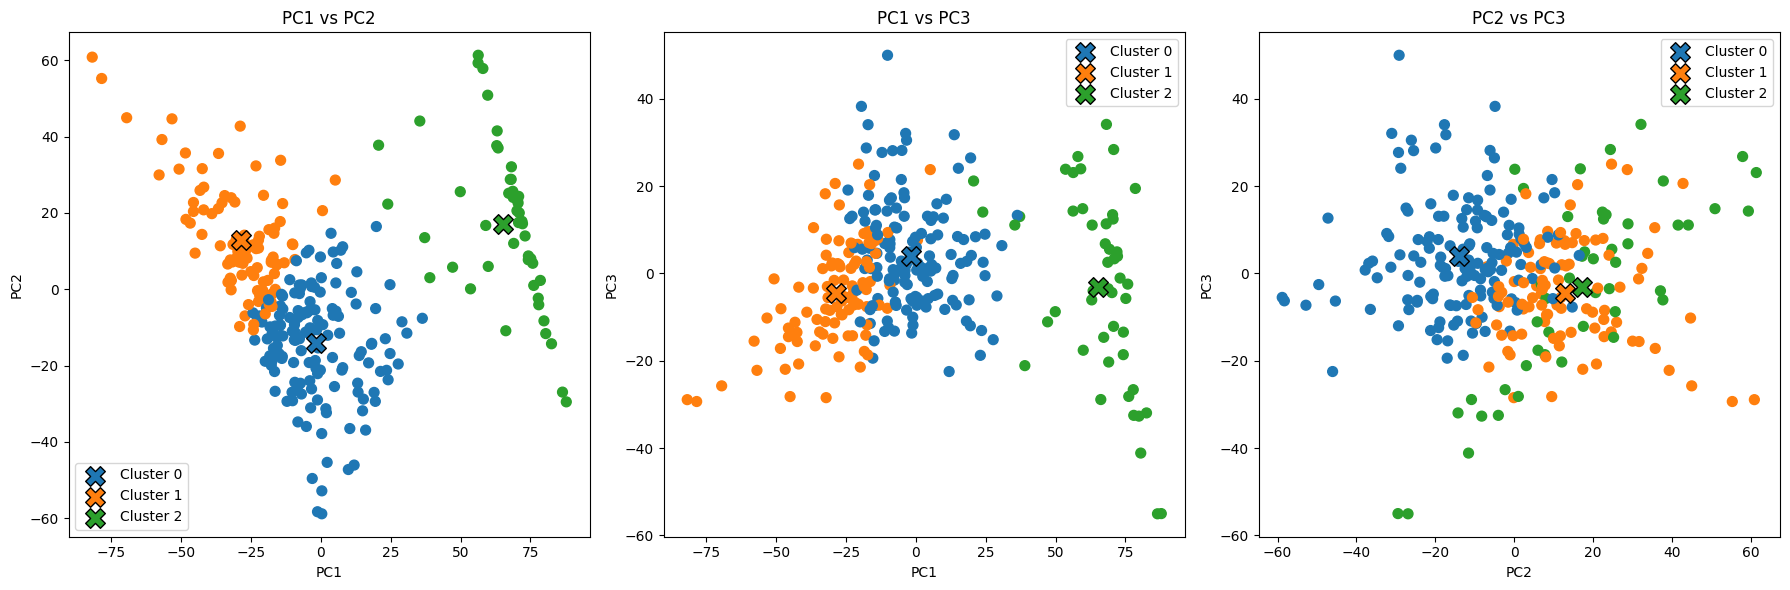

In [34]:
choosen_clusters = 3
pca = PCA(n_components=3) # Se reduce a n componentes principales
X_pca = pca.fit_transform(X) # X_pca es el conjunto de datos reducido a n dimensiones

# Inicializar KMeans con los clusters escogidos inicialmente
kmeans = KMeans(n_clusters=choosen_clusters, random_state=seed1)
y_kmeans = kmeans.fit_predict(X_pca)  

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
centroids = kmeans.cluster_centers_

# Colores para los clusters
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
cmap = ListedColormap(colors)
labels = [f'Cluster {i}' for i in range(choosen_clusters)]

# Subplot 1: PC1 vs PC2
axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap=cmap, s=50)
for i, centroid in enumerate(centroids):
    axs[0].scatter(centroid[0], centroid[1], c=colors[i], s=200, marker='X', edgecolor='k', label=labels[i])
axs[0].set_title('PC1 vs PC2')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].legend()

# Subplot 2: PC1 vs PC3
axs[1].scatter(X_pca[:, 0], X_pca[:, 2], c=y_kmeans, cmap=cmap, s=50)
for i, centroid in enumerate(centroids):
    axs[1].scatter(centroid[0], centroid[2], c=colors[i], s=200, marker='X', edgecolor='k', label=labels[i])
axs[1].set_title('PC1 vs PC3')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC3')
axs[1].legend()

# Subplot 3: PC2 vs PC3
axs[2].scatter(X_pca[:, 1], X_pca[:, 2], c=y_kmeans, cmap=cmap, s=50)
for i, centroid in enumerate(centroids):
    axs[2].scatter(centroid[1], centroid[2], c=colors[i], s=200, marker='X', edgecolor='k', label=labels[i])
axs[2].set_title('PC2 vs PC3')
axs[2].set_xlabel('PC2')
axs[2].set_ylabel('PC3')
axs[2].legend()

# Ajustar diseño
plt.tight_layout()
plt.show()


# Conclusiones del análisis de las componentes principales realizado anteriormente
*  PC1: se buscará un valor bajo, pues son clientes fieles que compran con mucha frecuencia, con un importe y cantidad totales importante a pesar de tener un importe medio de compra bajo.
*  PC2: se buscará un valor alto, pues son clientes que compran bastante en general, tanto en importe total como importe medio y cantidad totales.
*  PC3: en valor altos encontramos a aquellos clientes que compran productos caros pero con poca cantidad total. Se puede potenciar un valor alto o bajo, dependerá del negocio.

In [35]:
score = silhouette_score(X_pca, y_kmeans, metric='euclidean')
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.364


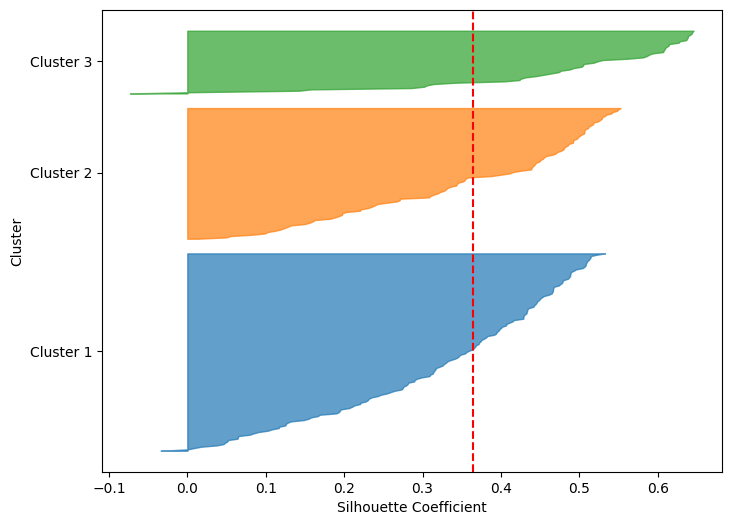

In [36]:
# Calcular valores de silhouette
silhouette_vals = silhouette_samples(X_pca, y_kmeans)
y_ticks = []
fig, ax1 = plt.subplots(figsize=(8, 6))

# Colores explícitos similares a viridis
cluster_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

y_lower = 10
for i in range(choosen_clusters):
    cluster_silhouette_vals = silhouette_vals[y_kmeans == i]
    cluster_silhouette_vals.sort()
    y_upper = y_lower + len(cluster_silhouette_vals)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_vals,
                      alpha=0.7, color=cluster_colors[i])  # Usamos los colores explícitos
    y_ticks.append((y_lower + y_upper) / 2)
    y_lower = y_upper + 10

# Añadir línea de Silhouette Score
ax1.axvline(x=score, color="red", linestyle="--")

# Configuración de los ejes
ax1.set_yticks(y_ticks)
ax1.set_yticklabels([f'Cluster {i+1}' for i in range(choosen_clusters)])
ax1.set_xlabel('Silhouette Coefficient')
ax1.set_ylabel('Cluster')

plt.show()

#   Análisis de resultados y clasificación de clientes

In [39]:
df_cluster_summary = df_summary.iloc[:,:8]
max_frequency = df_cluster_summary['frequency'].max()  # Obtener el valor máximo de 'frequency'
df_cluster_summary.fillna({'frequency':max_frequency}, inplace=True) 
df_cluster_summary['cluster'] = y_kmeans
df_cluster_summary

,total_orders,product,gender,sum_quantity,mean_quantity,sum_total,mean_total,frequency,cluster
clientId,,,,,,,,,
1,3,11,female,25,8.33,511,170.33,6.50,0
2,5,35,male,70,14.00,1229,245.80,18.25,1
3,1,4,female,9,9.00,137,137.00,96.00,2
4,5,24,male,50,10.00,885,177.00,14.00,1
5,3,19,male,34,11.33,609,203.00,17.50,0
...,...,...,...,...,...,...,...,...,...
296,2,6,female,9,4.50,115,57.50,2.00,0
297,2,12,female,27,13.50,567,283.50,77.00,2
298,3,13,female,27,9.00,475,158.33,32.00,0


In [40]:
df_cluster_summary = df_cluster_summary.groupby('cluster').agg(
    mean_total_orders=('total_orders', 'mean'),
    mean_product=('product', 'mean'),
    mean_sum_quantity=('sum_quantity', 'mean'),
    mean_mean_quantity=('mean_quantity', 'mean'),
    mean_sum_total=('sum_total', 'mean'),
    mean_mean_total=('mean_total', 'mean'),
    mean_frequency=('frequency', 'mean'),
    num_clients=('cluster', 'size')  # Número de clientes por cluster
)

df_cluster_summary

,mean_total_orders,mean_product,mean_sum_quantity,mean_mean_quantity,mean_sum_total,mean_mean_total,mean_frequency,num_clients
cluster,,,,,,,,
0,3.087248,13.288591,25.711409,8.458859,455.711409,149.901879,21.887450,149
1,4.777778,25.464646,51.393939,11.031212,951.121212,204.491717,17.247071,99
2,1.250000,6.333333,12.062500,9.729167,216.250000,173.468750,90.854167,48
